# Simulations pour le nouveau modèle


### Dépendances et Fonctions

In [1]:
#coding: utf-8
import os
import sys
import logging

import pandas as pd
import numpy as np
import datetime as dt


# Functions, read data sets
def read_npz_dataset(train_test = "train"):
    if train_test != "train":
        train_test = "validation"
        
    
    # Read data
    data = np.load("data/data_{}.npz".format(train_test), allow_pickle = True)
    
    Xa = data["Xa"]/10000
    X_gp = data["Xgpa"]/10000
    Ya = data["Ya"]
    Ta = data["Ta"]

    # Transform data
    X_ = []; T = []; C_ = []
    for i in range(Xa.shape[0]):
        # Remove double values in the time (reflectance seen twice)
        T_un, indx_un = np.unique(Ta[i], return_index = True)
        # If the input vector is not empty
        if Xa[i].ndim == 2 and indx_un.shape[0] > 0:
            X_.append([np.array(Xa[i][b, indx_un]) for b in range(10)])
            T.append(Ta[i][indx_un])
            C_.append(Ya[i])
            
    # To numpy array
    X_ = np.array(X_, dtype = object); T = np.array(T, dtype = object)
    X_ = np.concatenate((T[:, np.newaxis], X_), axis = 1)
    C_ = np.array(C_)

    t_ = np.array([X_[i, 0].astype(int) for i in range(X_.shape[0])], dtype = object)

    return X_, t_, X_gp, C_

### Extraction des données

In [2]:
data_type = "real" # "real" "simulated"

# Real data
if data_type == "real":
    X_train, t_train, X_gp_train, C_train = read_npz_dataset(train_test = "train")
    X_test, t_test, X_gp_test, C_test = read_npz_dataset(train_test = "test")

# Simulated data
else:
    print(0)
    
    
CLASSES = np.unique(C_train)
nc = CLASSES.shape[0]

### M2GP Model

In [3]:
%load_ext autoreload
%autoreload 2
# Classifier
from mult_model import M2GP

# Dependecies
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Ck, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic


# Model parameters
K = Ck(1.0, constant_value_bounds=(1e-05, 1e5)) \
    * Matern(1., length_scale_bounds=(1e-05, 1e5), nu = 0.5) \
    + WhiteKernel(noise_level=0.01,
                  noise_level_bounds=(1e-10, 1e+1))
basis_ = "fourier"
n_basis_ = 9
tau_ = 365

In [4]:
from pickle import load

# Load models
with open("./models/S2_models/model_kernel_0.pkl", "rb") as theFile:
    model = load(theFile)
with open("./models/S2_models/model_kernel_1.pkl", "rb") as theFile:
    model2 = load(theFile)

### Affichage des matrices de covariances

#### $AA^\top$

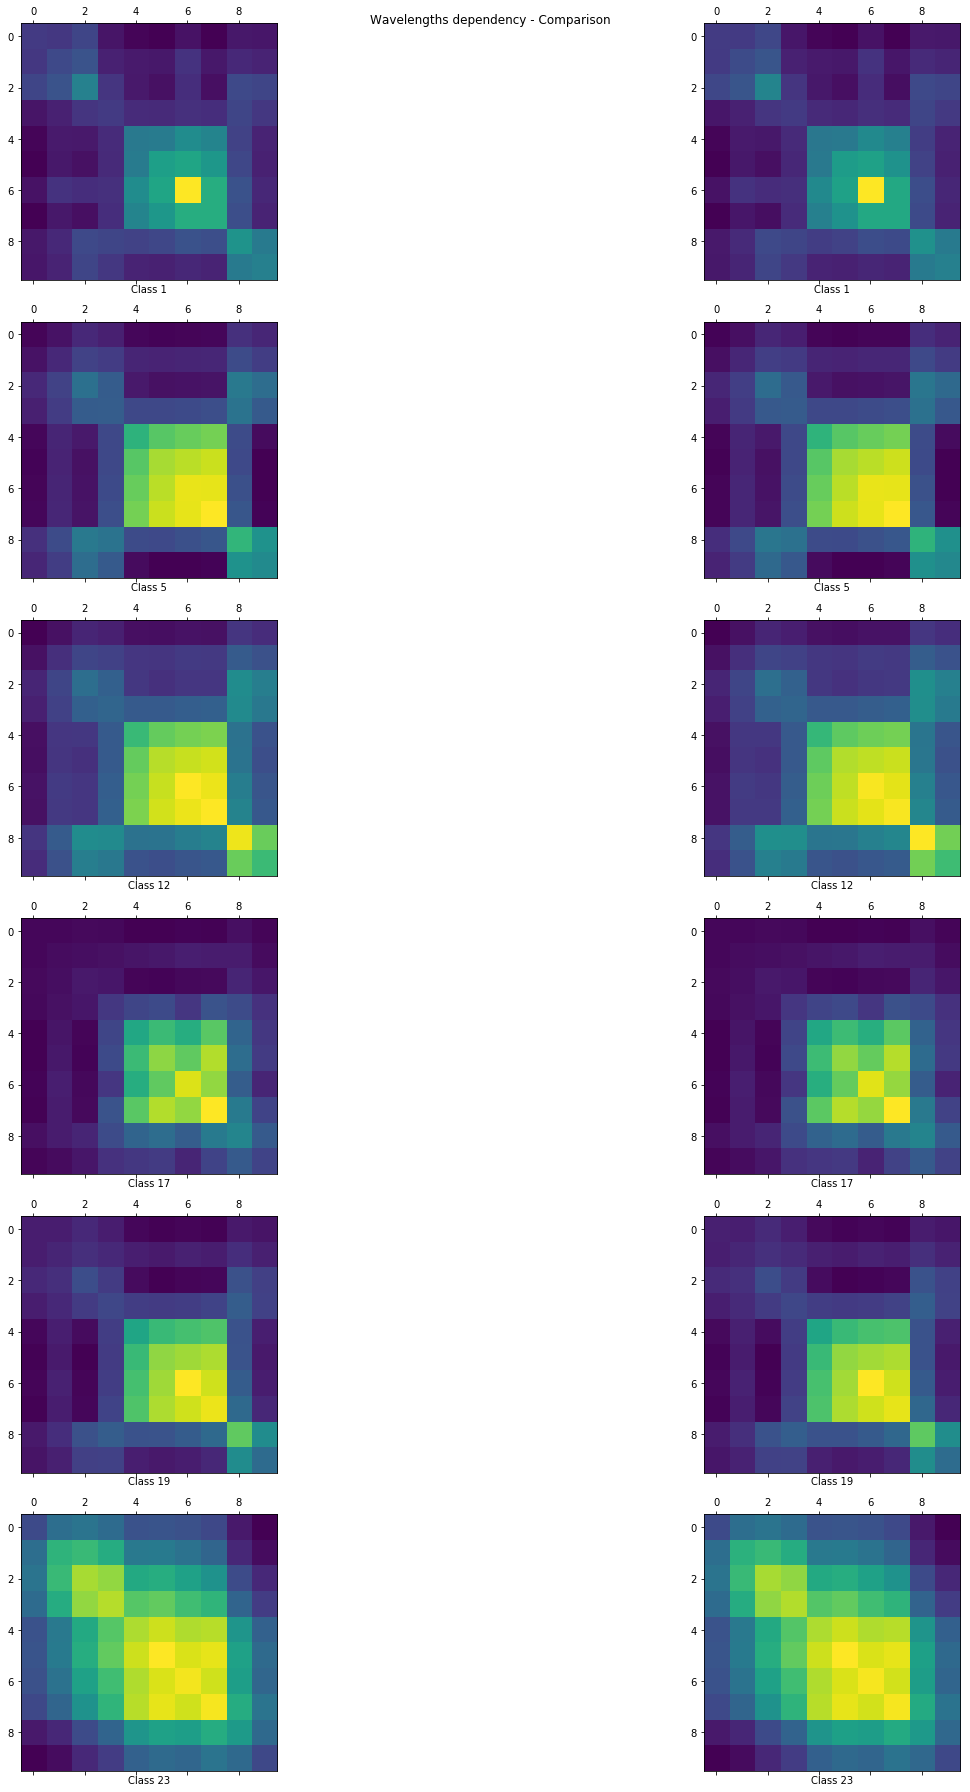

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# Print Ac t(Ac)
fig = plt.figure(figsize=(25,25))

classes_selection = [1, 5, 12, 17, 19, 23]
l = 0
for c in range(CLASSES.shape[0]):  
    if CLASSES[c] == classes_selection[l]:
        ax = fig.add_subplot(len(classes_selection), 2, l*2+1)
        # Plot matrix for A
        ax.matshow(model.AA_T_[c])
        ax.set_xlabel("Class {}".format(CLASSES[c]))
        
        ax = fig.add_subplot(len(classes_selection), 2, l*2+2)
        # Plot matrix for A
        ax.matshow(model2.AA_T_[c])
        ax.set_xlabel("Class {}".format(CLASSES[c]))

        l+=1
    
fig.suptitle("Wavelengths dependency - Comparison", y=0.99)
fig.tight_layout()

##### Matrice de covariance en temps

Affichage de la ligne de $K_{\theta}(t, s)$ à t fixé (180 jours);
$s$ allant de 0 à 360 jours.

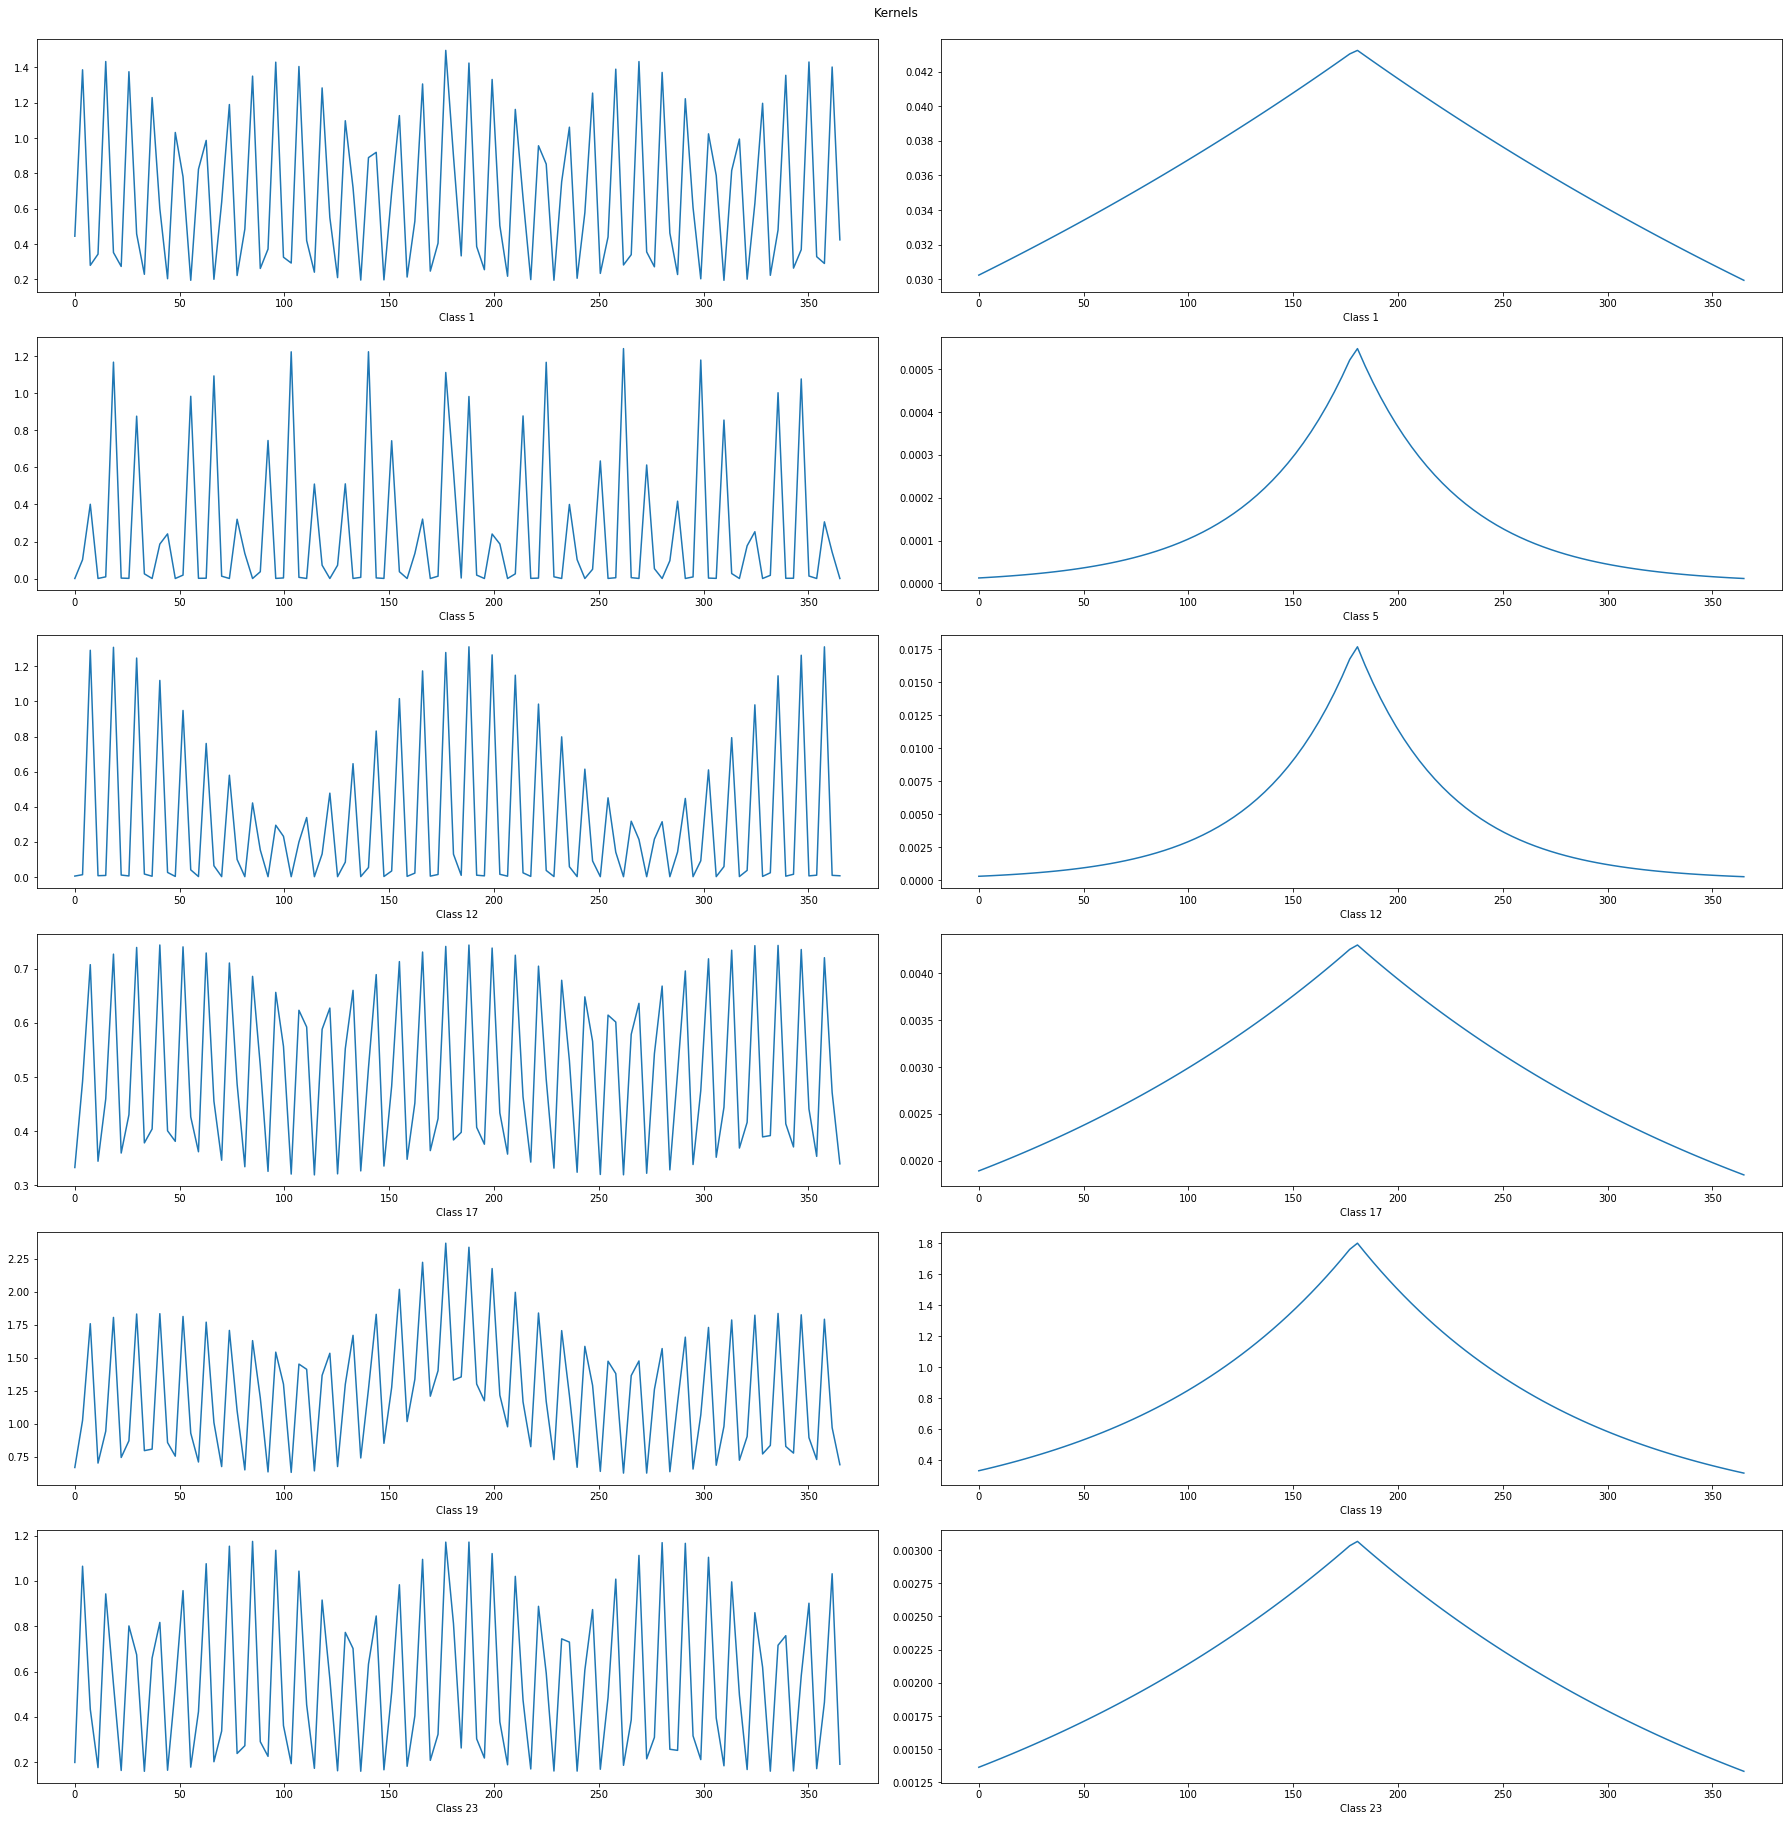

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

t_fixe = np.array([180])
t_ = np.linspace(0, 365, 100).reshape(-1, 1)

# Print kernel in time
fig = plt.figure(figsize=(25,25))

classes_selection = [1, 5, 12, 17, 19, 23]
l = 0
for c in range(CLASSES.shape[0]):  
    if CLASSES[c] == classes_selection[l]:
        ax = fig.add_subplot(len(classes_selection), 2, l*2+1)
        # Plot centered kernel
        ax.plot(t_, model.kernels["{}".format(c)](t_fixe, t_)[0])
        ax.set_xlabel("Class {}".format(CLASSES[c]))
        
        ax = fig.add_subplot(len(classes_selection), 2, l*2+2)
        # Plot centerd kernel
        ax.plot(t_, model2.kernels["{}".format(c)](t_fixe, t_)[0])
        ax.set_xlabel("Class {}".format(CLASSES[c]))

        l+=1
    
fig.suptitle("Kernels", y=1.01)
fig.tight_layout()

Affichage de $AA^\top \otimes \Sigma(\theta)$

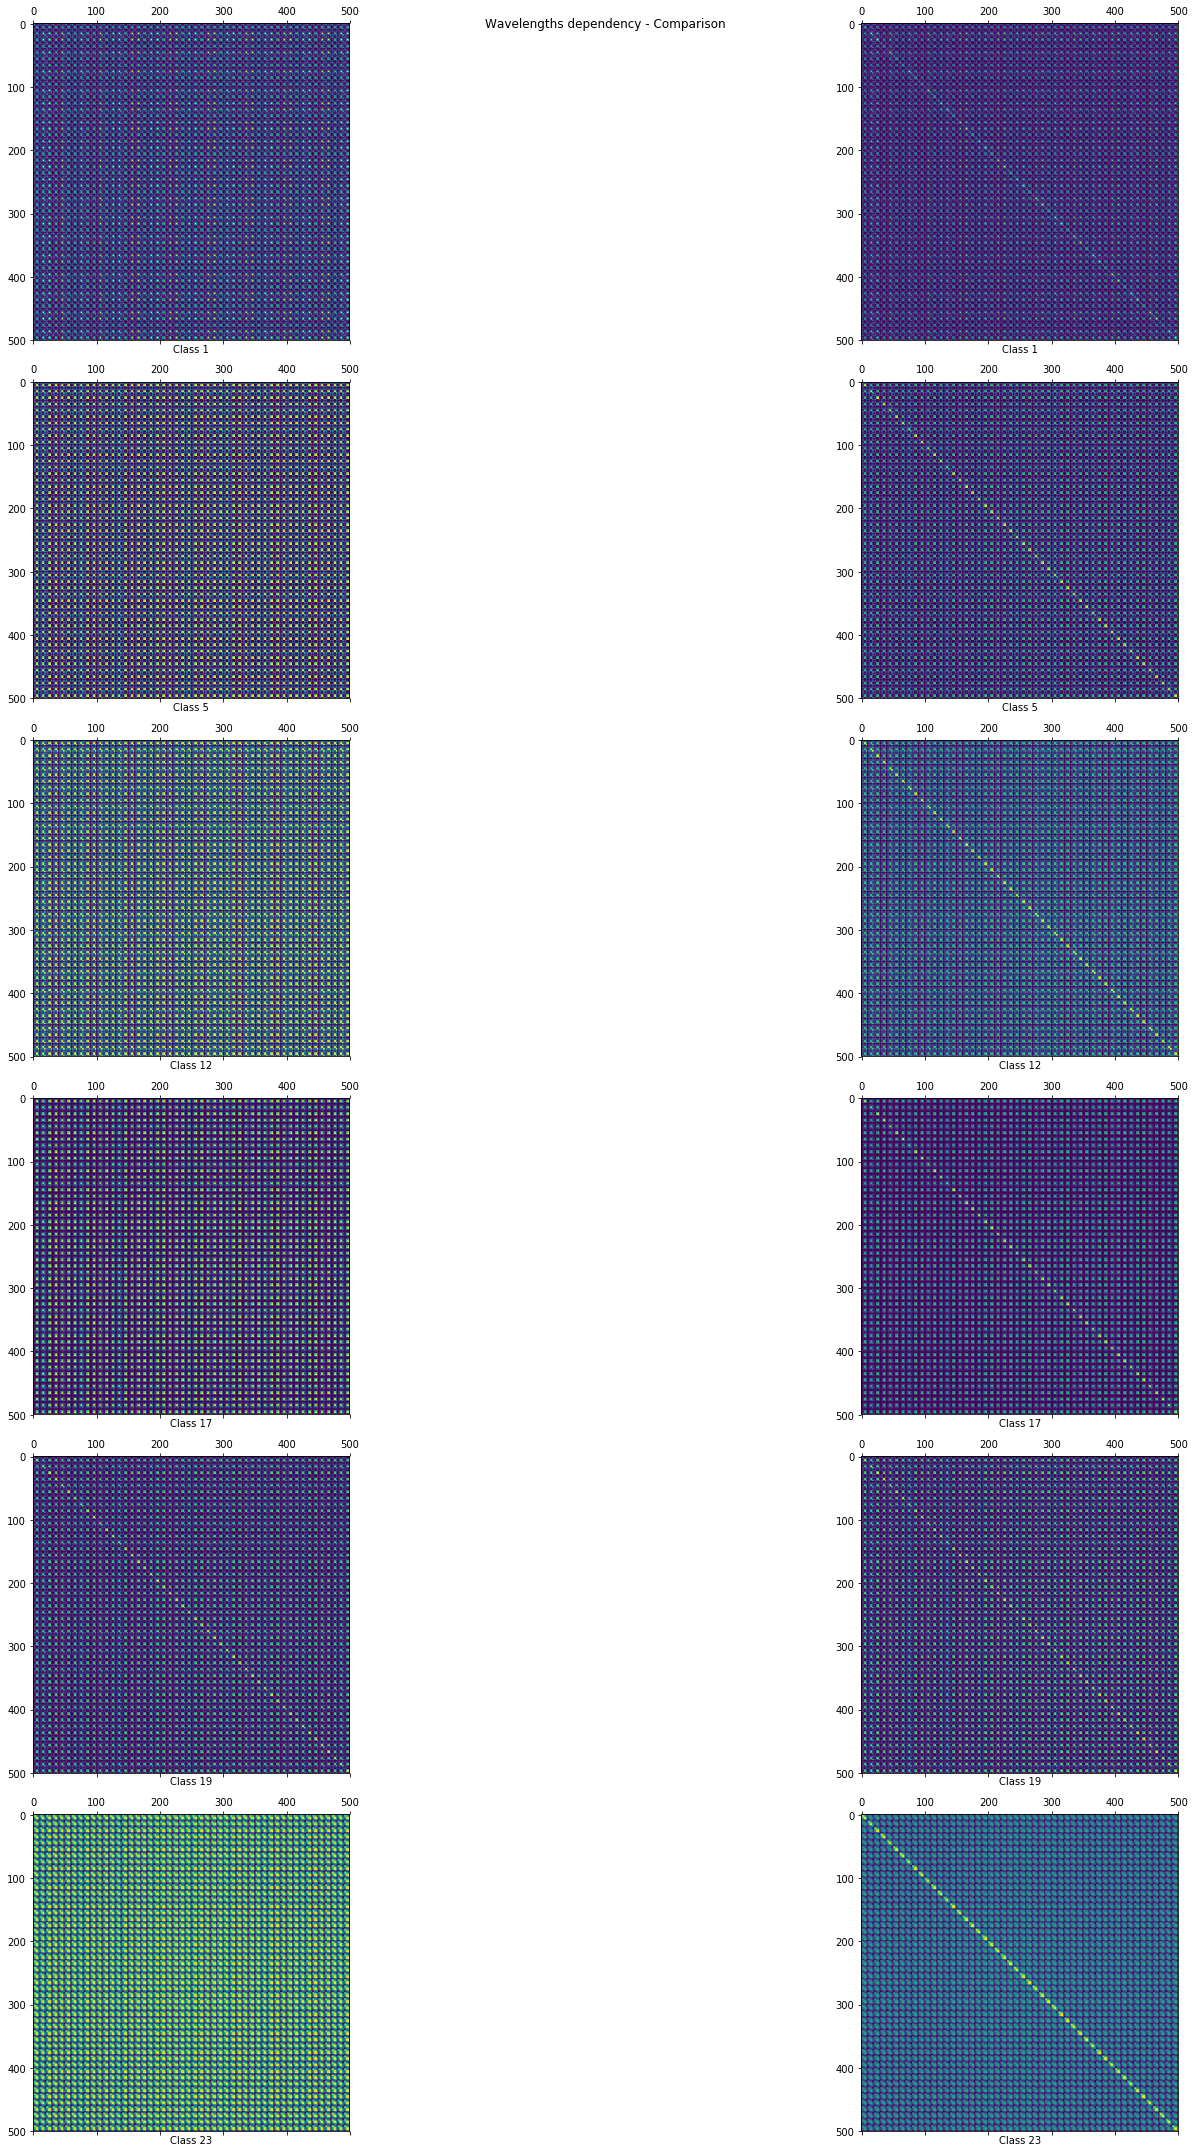

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# Print Ac t(Ac)
fig = plt.figure(figsize=(30,30))

classes_selection = [1, 5, 12, 17, 19, 23]
l = 0
for c in range(CLASSES.shape[0]):  
    if CLASSES[c] == classes_selection[l]:
        ax = fig.add_subplot(len(classes_selection), 2, l*2+1)
        # Plot matrix for A
        K = model.kernels["{}".format(c)]
        ax.matshow(np.kron(K(np.linspace(0, 365)), model.AA_T_[c]))
        ax.set_xlabel("Class {}".format(CLASSES[c]))
        
        ax = fig.add_subplot(len(classes_selection), 2, l*2+2)
        # Plot matrix for A
        K = model2.kernels["{}".format(c)]
        ax.matshow(np.kron(K(np.linspace(0, 365)), model2.AA_T_[c]))
        ax.set_xlabel("Class {}".format(CLASSES[c]))

        l+=1
    
fig.suptitle("Wavelengths dependency - Comparison", y=0.99)
fig.tight_layout()

### Scores du modèle - OA et Reconstruction de la moyenne

1. Affichage des scores en fonction du nombre d'instants observés.

In [8]:
results = model2.predict(X_test)

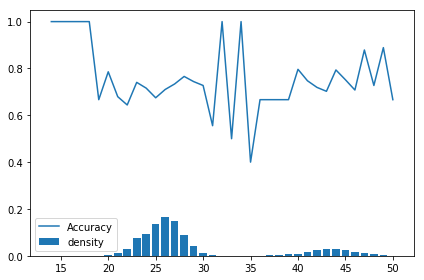

In [9]:
longueurs_TS = [X_test[i, 0].shape[0] for i in range(X_test.shape[0])]

longueurs_un = np.unique(longueurs_TS)

results_per_len = np.zeros_like(longueurs_un)
sum_of_tests = np.zeros_like(longueurs_un)

for i in range(X_test.shape[0]):
    ind = np.argwhere(longueurs_un == longueurs_TS[i])[0][0]
    sum_of_tests[ind] += 1
    if C_test[i] == results[i]:
        results_per_len[ind] += 1
   
%matplotlib inline

scores_per_Ti = np.divide(results_per_len, sum_of_tests)
plt.plot(longueurs_un, scores_per_Ti, label = "Accuracy")
plt.bar(longueurs_un, sum_of_tests / X_test.shape[0], label = 'density')
plt.legend()
plt.tight_layout()

2. Reconstruction de la moyenne

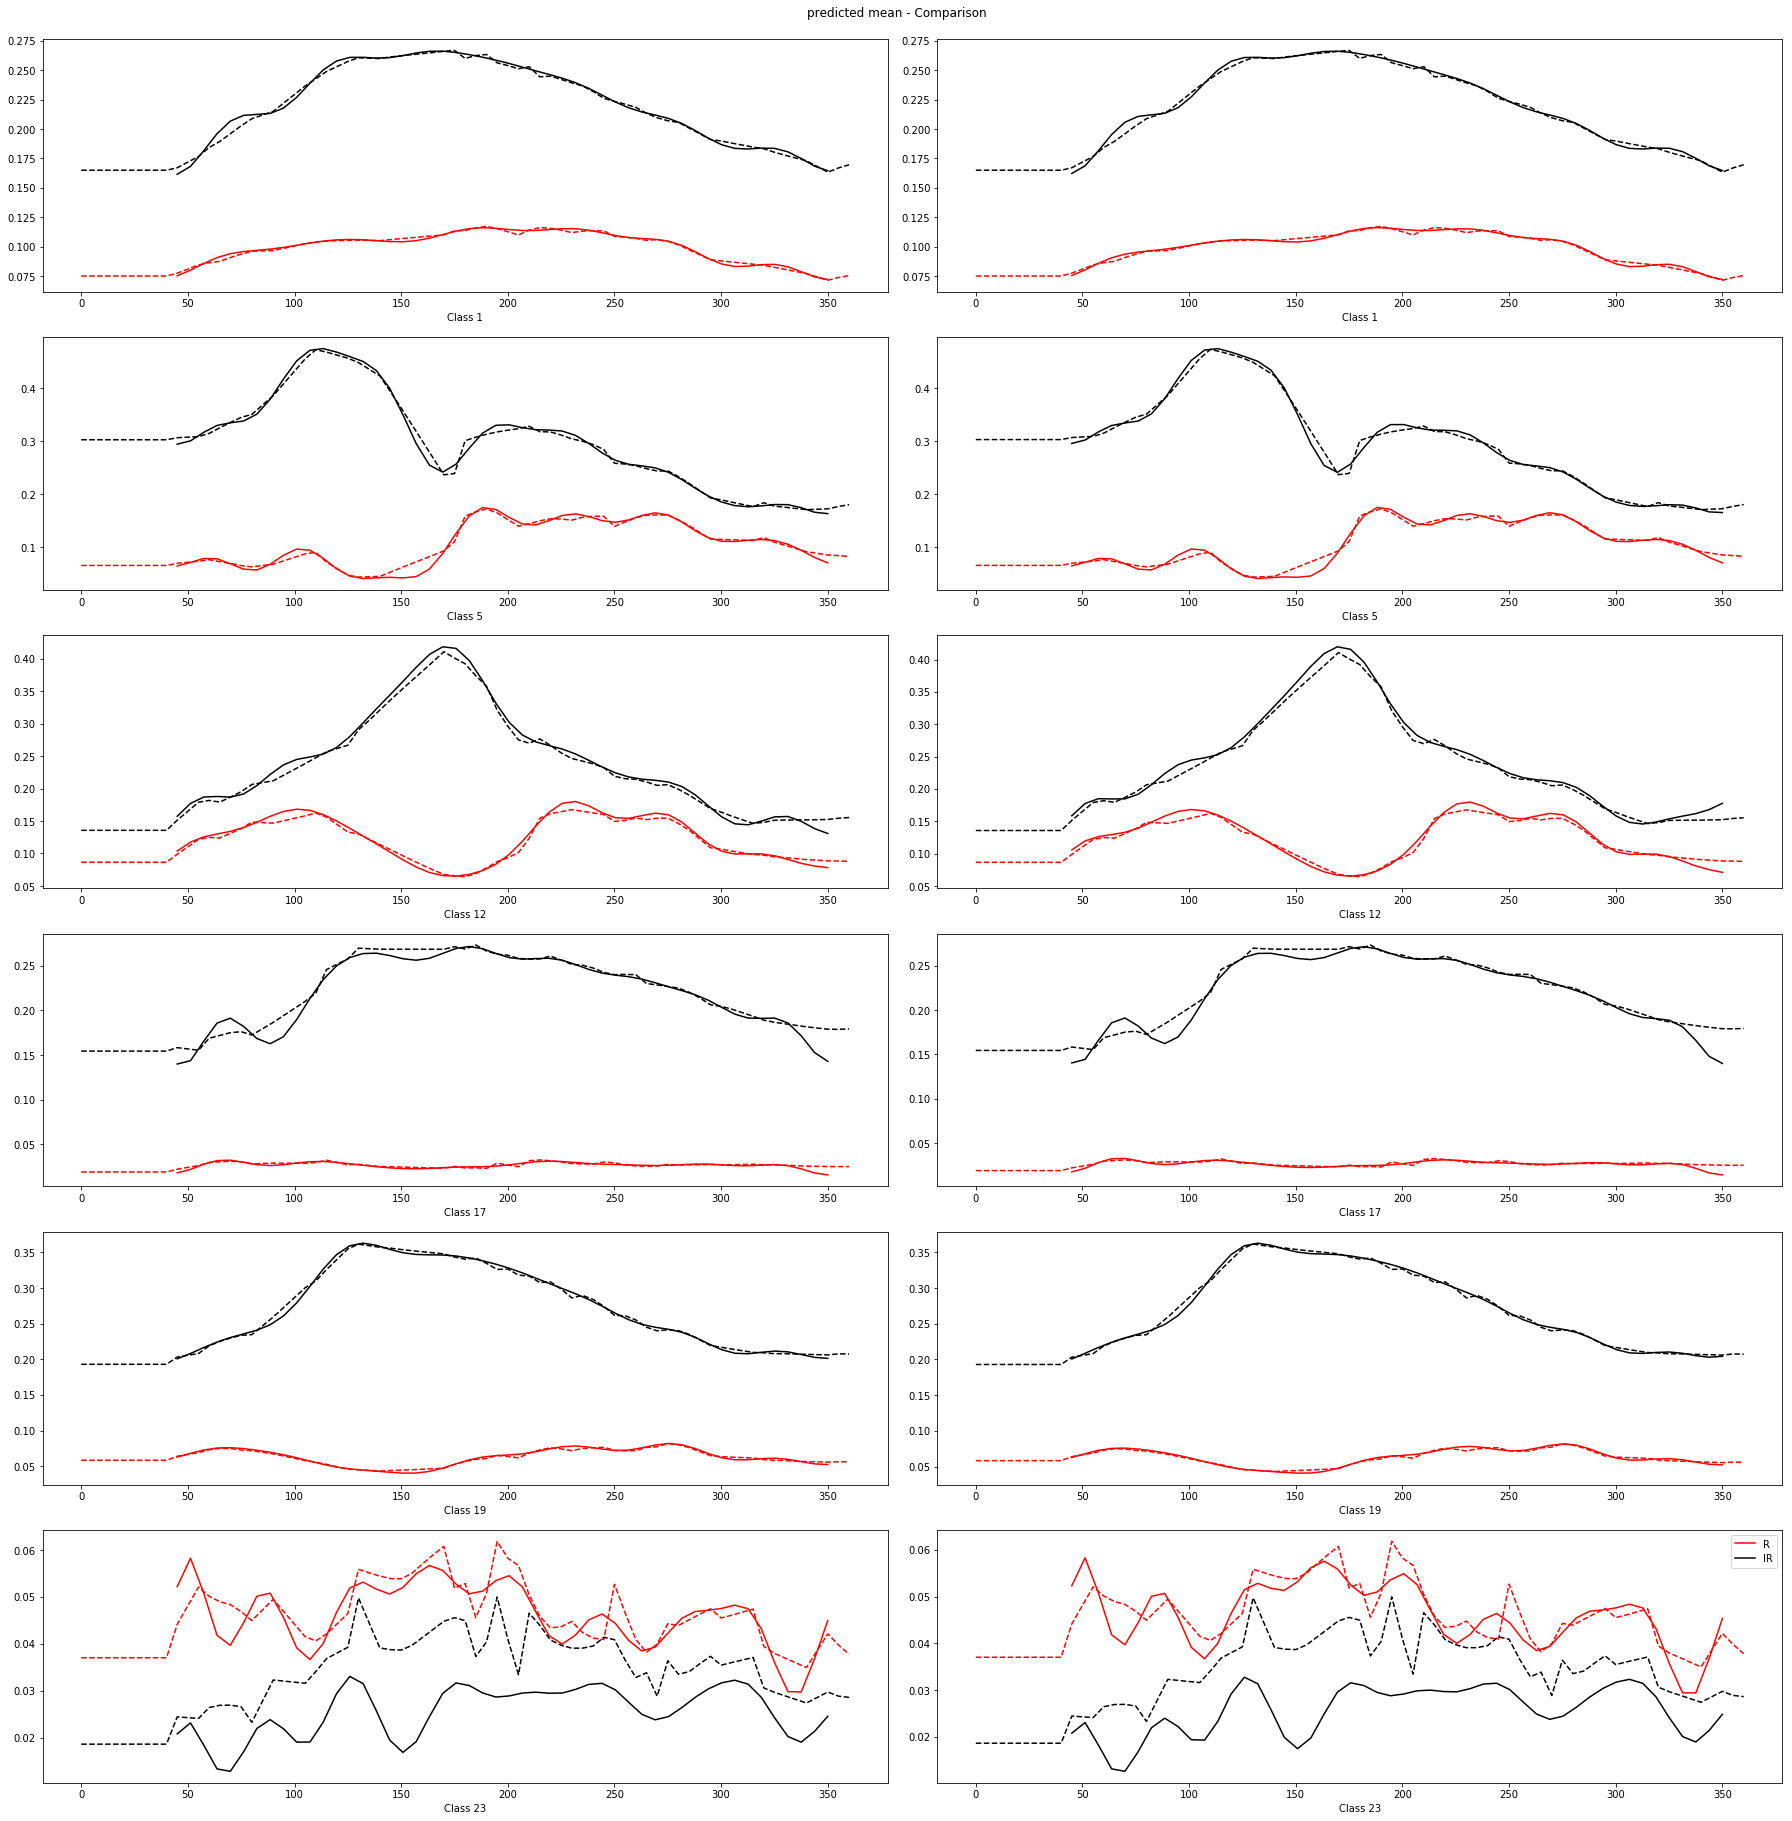

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline


# Read gap-filled dates
timeSample_gp = np.loadtxt("data/TimeSeriesOutputDateFile.txt").astype(str)
dateSample_gp = pd.DatetimeIndex([dt.datetime(int(t[:4]), int(t[4:6]), int(t[6:8])) \
                                for t in timeSample_gp])
nDates_gp = dateSample_gp.size
# Transform dates into vector of floats - Time samples in train / test data
min_julian_date = dateSample_gp.to_julian_date().min()
timeSamples_gp = dateSample_gp.to_julian_date() - min_julian_date



# Print alpha B
t_ = np.linspace(45, 350)
fig = plt.figure(figsize=(25,25))

classes_selection = [1, 5, 12, 17, 19, 23]
colors = ['r', 'k']
l = 0
B = model2.design_matrix(t_)
for c in range(CLASSES.shape[0]):  
    if CLASSES[c] == classes_selection[l]:
        # Obtain indexes for gap-filled data
        indxs = np.argwhere(C_train == CLASSES[c]).flatten()
        X_gp_indxs = X_gp_train[indxs, :, :]
        
        ax = fig.add_subplot(len(classes_selection), 2, l*2+1)
        # Plot mean for model 1
        means = np.dot(model.alpha_[c], B)
        ax.plot(t_, means[2, :], '{}-'.format(colors[0]), label = 'R')
        ax.plot(timeSamples_gp, np.mean(X_gp_indxs[:, 2, :], axis = 0), '{}--'.format(colors[0]))
        ax.plot(t_, means[6, :], '{}-'.format(colors[1]), label = 'IR')
        ax.plot(timeSamples_gp, np.mean(X_gp_indxs[:, 6, :], axis = 0), '{}--'.format(colors[1]))
        ax.set_xlabel("Class {}".format(CLASSES[c]))
        
        ax = fig.add_subplot(len(classes_selection), 2, l*2+2)
        # Plot mean for model 2
        means = np.dot(model2.alpha_[c], B)
        ax.plot(t_, means[2, :], '{}-'.format(colors[0]), label = 'R')
        ax.plot(timeSamples_gp, np.mean(X_gp_indxs[:, 2, :], axis = 0), '{}--'.format(colors[0]))
        ax.plot(t_, means[6, :], '{}-'.format(colors[1]), label = 'IR')
        ax.plot(timeSamples_gp, np.mean(X_gp_indxs[:, 6, :], axis = 0), '{}--'.format(colors[1]))
        ax.set_xlabel("Class {}".format(CLASSES[c]))

        l+=1
    
fig.suptitle("predicted mean - Comparison", y=1.01)
plt.legend()
fig.tight_layout()